# Parsing Table Data into Graphs

In [1]:
import pandas as pd

df1 = pd.read_csv('data/activity_list.csv')
df1.head()

,ID,Activity,Optimistic,Normal,Pessimistic
0,1,A,2,4,6
1,2,B,3,5,9
2,3,C,4,5,7
3,4,D,4,6,10
4,5,E,4,5,7


In [2]:
df1['Expected'] = (df1['Optimistic'] + 4*df1['Normal'] + df1['Pessimistic']) / 6.0
df1.head()

,ID,Activity,Optimistic,Normal,Pessimistic,Expected
0,1,A,2,4,6,4.000000
1,2,B,3,5,9,5.333333
2,3,C,4,5,7,5.166667
3,4,D,4,6,10,6.333333
4,5,E,4,5,7,5.166667


In [3]:
df2 = pd.read_csv('data/edge_list.csv')
df2.head()

,ID,Parent,Child
0,1,1,3
1,2,1,4
2,3,2,5
3,4,3,5
4,5,4,6


In [4]:
import networkx as nx

G = nx.DiGraph()

for index, row in df1.iterrows():
    G.add_node(row['Activity'])
    G.node[row['Activity']]['Optimistic'] = row['Optimistic']
    G.node[row['Activity']]['Normal'] = row['Normal']
    G.node[row['Activity']]['Pessimistic'] = row['Pessimistic']
    G.node[row['Activity']]['Expected'] = row['Expected']
    
dict(G.nodes(data=True))

{'A': {'Optimistic': 2, 'Normal': 4, 'Pessimistic': 6, 'Expected': 4.0},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.333333333333333},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667},
 'D': {'Optimistic': 4,
  'Normal': 6,
  'Pessimistic': 10,
  'Expected': 6.333333333333333},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667},
 'F': {'Optimistic': 3, 'Normal': 4, 'Pessimistic': 8, 'Expected': 4.5},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.166666666666667}}

In [5]:
for index, row in df2.iterrows():
    u = df1.at[row['Parent']-1, 'Activity']
    v = df1.at[row['Child']-1, 'Activity']
    G.add_edge(u, v)
    
G.edges()

OutEdgeView([('A', 'C'), ('A', 'D'), ('B', 'E'), ('C', 'E'), ('D', 'F'), ('E', 'G')])

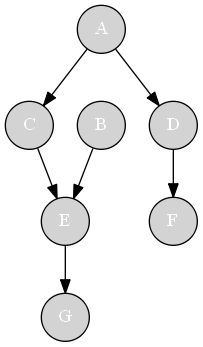

In [6]:
import networkx.drawing.nx_pydot as pdt
from IPython.display import Image, display

def display_graph(G):
    A = pdt.to_pydot(G)
    for i, node in enumerate(A.get_nodes()):
        node.set_shape('circle')
        node.set_style('filled')
        node.set_fontcolor('#FFFFFF')
    plt = Image(A.create_png())
    display(plt)
    
display_graph(G)

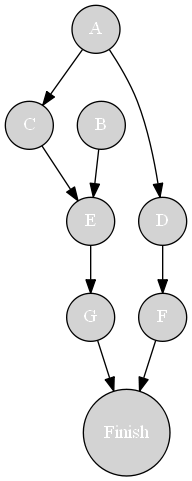

In [7]:
def add_finish_node(G, nbunch):
    G.add_node('Finish')
    G.node['Finish']['Optimistic'] = 0
    G.node['Finish']['Normal'] = 0
    G.node['Finish']['Pessimistic'] = 0
    G.node['Finish']['Expected'] = 0
    for node in nbunch:
        G.add_edge(node, 'Finish')
    return G
        
G = add_finish_node(G, ['G', 'F'])
display_graph(G)

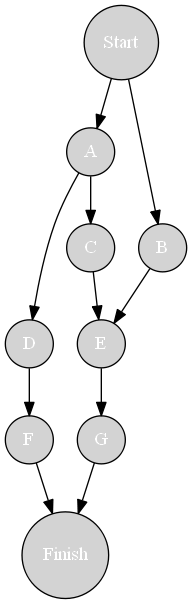

In [8]:
def add_start_node(G, finish):
    G.add_node('Start')
    G.node['Start']['Optimistic'] = 0
    G.node['Start']['Normal'] = 0
    G.node['Start']['Pessimistic'] = 0
    G.node['Start']['Expected'] = 0
    roots = [node for node in nx.ancestors(G, finish) if not list(G.predecessors(node))]
    for node in roots:
        G.add_edge('Start', node)
    return G

G = add_start_node(G, 'Finish')
display_graph(G)

In [9]:
for node in nx.topological_sort(G):
    parents = list(G.predecessors(node))
    if not parents:
        G.node[node]['Early Start'] = 0
    else:
        parent = max(parents, key=lambda x: G.node[x]['Early Finish'])
        G.node[node]['Early Start'] = G.node[parent]['Early Finish']
    G.node[node]['Early Finish'] = G.node[node]['Early Start'] + G.node[node]['Expected']
    
dict(G.nodes(data=True))    

{'A': {'Optimistic': 2,
  'Normal': 4,
  'Pessimistic': 6,
  'Expected': 4.0,
  'Early Start': 0,
  'Early Finish': 4.0},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.333333333333333,
  'Early Start': 0,
  'Early Finish': 5.333333333333333},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667,
  'Early Start': 4.0,
  'Early Finish': 9.166666666666668},
 'D': {'Optimistic': 4,
  'Normal': 6,
  'Pessimistic': 10,
  'Expected': 6.333333333333333,
  'Early Start': 4.0,
  'Early Finish': 10.333333333333332},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667,
  'Early Start': 9.166666666666668,
  'Early Finish': 14.333333333333336},
 'F': {'Optimistic': 3,
  'Normal': 4,
  'Pessimistic': 8,
  'Expected': 4.5,
  'Early Start': 10.333333333333332,
  'Early Finish': 14.833333333333332},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.166666666666667,
  'Early 